# Section 10 Linear regression

In [1]:
library(ggplot2)
library(tidyr)
library(magrittr)
library(gridExtra)

# install.packages("HistData")
library(data.table)
library(tidyverse)
library(HistData)

# install.packages("Lahman")
library(Lahman)

options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 100)



Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()    masks data.table::between()
✖ dplyr::combine()    masks gridExtra::combine()
✖ magrittr::extract() masks tidyr::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks data.table::first()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::last()       masks data.table::last()
✖ purrr::set_names()  masks magrittr::set_names()
✖ purrr::transpose()  masks data.table::transpose()


In [2]:
# --------------------

## Motivation and Overview

### 1. Testing Conditional Independence

So far: test associations between pairs of variables

In data science: study >2 variables jointly.

---

*For pairs of variables*:

$x$ explanatory variable, $y$ response variable.

Question "does $y$ depend on $x$?" equivalent to "does conditional distribution of $y$ given $x$ vary when $x$ varies?", i.e. $H_{0}: p(y|x) = p(y)$.

---

*For multiple explanatory variables*:

$x_{1}, \ldots, x_{p}$ explanatory variables, $y$ response variable.

Question "does $y$ depend on $x_{j}$?" equivalent to "does conditional distribution of $y$ given all explanatory variables vary when only$x_{j}$ varies?", i.e. $H_{0}: p(y|x_{1}, \ldots, x_{p}) = p(y|x_{1}, \ldots, x_{j-1},x_{j+1}, \ldots, x_{p})$.

Problem: this equation is impractical as
1. any type of distribution possible, e.g. Gaussian, Binomial, Poisson, mixtures, not fully parametrized ones.
2. condition on continuos variable(s), i.e. how to deal with it? (if categorical: stratification of data)
3. combinatorial explosion of strata (even with only categorical variables) due to splits of every stratum by every new added variable, i.e. $2^{p}$ different strata for $p$ binary variables.

Solution: linear regression.

### 2. Linear Regression

Assumptions:
1. $p(y|x_{1}, \ldots, x_{p})$ Gaussian distribution with variance independent of $x_{1}, \ldots, x_{p}$, also calles strata (simplyfies problem 1).
2. $E[y|x_{1}, \ldots, x_{p}] = \beta_{0} + \sum_{i=1}^{p} \beta_{i} x_{i} \quad \forall y$ (solves problem 2).

Assumption 2 models independent additive contributions of explanatory variables, hence effects of explanatory variables independent of values of other variables. Effects do not change between strata as effects of explanatory variables do not depend on value of ther variables, hence problem 3 is solved.


Remark: equation in assumption 2 $\approx$ score for which explanatory variables contribute in weighted fashion and independent of each other to variations in expected value of response.

### 3. Limitations

Assumption 1:
- Gaussian distribution very limiting, i.e. no binary response variables possible.
- independent variance very limiting, e.g. for statistical testing.

Assumption 2:
- not that limiting, often already fulfilled. Also: non-linear transformations of explanatory variables can be pre-computed and included in model.

Remark: assumptions often reasonable in practice.

### 4. Applications

Examples:
- test conditional independence via null hypothesis $H_{0}: \beta_{j} = 0$.
- estimation of effects of one variable on response variable via estimation of according coefficient $\beta_{j}$.
- predict value of response variable given values of explanatory variables via $E[y|x]$.
- quantify how much variation of response variable can be explained by set of explanatory variables.

In [3]:
# --------------------

## Univariate Regression

Linear regression against one variable.

### 1. Galton's Height Dataset (from `HistData` package)

Imitate Galton's analysis: how well can we predict height on child based on parents' height?

Dataset: take heights of fathers and randomly selected son of each family.

---

Result: plots indicate that linear model is $E[\mathrm{son}|\mathrm{father}] = \beta_{0} + \beta_{1} \cdot \mathrm{father}$.

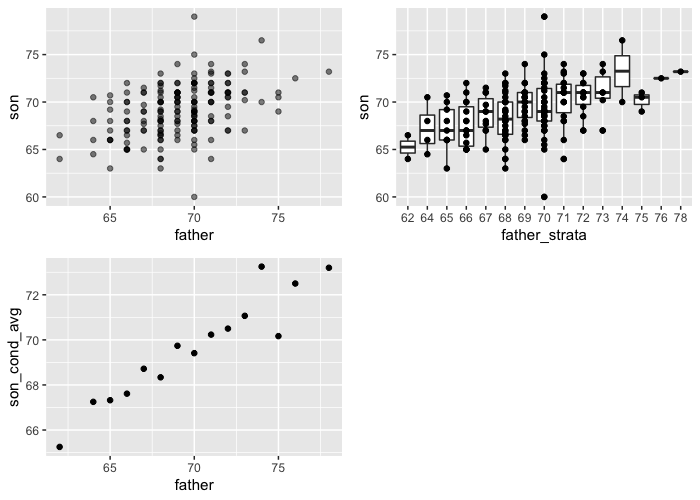

In [4]:
data("GaltonFamilies")
GaltonFamilies <- as.data.table(GaltonFamilies)
set.seed(1983)
galton_heights <- GaltonFamilies[gender == 'male'][,.SD[sample(.N, 1L)],by = family][,.(father, childHeight)]
setnames(galton_heights, "childHeight", "son")

grid.arrange(
    galton_heights %>% ggplot(aes(father, son)) + 
      geom_point(alpha = 0.5),
    galton_heights[, father_strata := factor(round(father))] %>% # p(son|father), i.e. visualization of cond. dist.
      ggplot(aes(father_strata, son)) + 
      geom_boxplot() + 
      geom_point(),
    galton_heights[, father := round(father)][
        ,.(son_cond_avg = mean(son)), by=father] %>% # conditional expectation by stratification
      ggplot(aes(father, son_cond_avg)) +
      geom_point(),
    ncol=2, nrow=2)

# interpretation: the taller the father, the taller the son

In [5]:
# predict height for son of 72 inch tall father:
conditional_avg <- galton_heights[round(father) == 72, mean(son)]
conditional_avg

[1] 70.5

### 2. Maximum Likelihood and Least Squares Estimates (`lm()`)

Maximum likelihood: choosing values for parameters s.t. data most probable for them, i.e. $\mathrm{argmax}_{\beta_{0}, \beta_{1}} p(\mathrm{Data}|\beta_{0}, \beta_{1}) = \mathrm{argmax}_{\beta_{0}, \beta_{1}} \Pi_{i} p(y_{i}|x_{i}, \beta_{0}, \beta_{1})$ with assumptions that
1. explanatory variables given
2. observations independent if conditioned on values of explanatory variable.

Maximum log-likelihood: $\mathrm{argmax}_{\beta_{0}, \beta_{1}} \Pi_{i} p(y_{i}|x_{i}, \beta_{0}, \beta_{1}) = \mathrm{argmax}_{\beta_{0}, \beta_{1}} \sum_{i} log(N(y_{i}|x_{i}, \beta_{0}, \beta_{1})) = \mathrm{argmin}_{\beta_{0}, \beta_{1}} (y_{i} - (\beta_{0} + \beta_{1}x_{i}))^{2}$.

Remark: $N(y_{i}|x_{i}, \beta_{0}, \beta_{1}) = N(y_{i}|\beta_{0} + \beta_{1} x_{1}, \sigma^{2}) = \frac{1}{\sigma \sqrt{2\pi}} \cdot \mathrm{exp}(-\frac{1}{2} \frac{(y_{i} - (\beta_{0} + \beta_{1} x_{1}))^{2}}{\sigma^{2}})$

Differences between observed and expected value: $\epsilon_{i} = y_{i} - (\beta_{0} + \beta_{1}x_{i})$ ("errors").

---

Summary: maximizing likelihood of specific model $\approx$ minimize sum of squared errors, i.e. least squares estimates.

### 3. Interpretation of Fitted Coefficients

Obtained estimated conditional expected value: $\hat{y} = \hat{\beta_{0}} + \hat{\beta_{1}} x_{i}$ with slope $\hat{\beta_{1}} = \rho \frac{\sigma_{y}}{\sigma_{x}}$, intercept $\hat{\beta_{0}} = \mu_{y} - \hat{\beta_{1}} \mu_{x}$, where
1. $\mu_{x}$, $\mu_{y}$ = means of $x$, $y$
2. $\sigma_{x}$, $\sigma_{y}$ = standard deviations of $x$, $y$
3. $\rho = \frac{1}{n} \sum_{i=1}^{n} (\frac{x_{i} - \mu_{x}}{\sigma_{x}}) (\frac{y_{i} - \mu_{y}}{\sigma_{y}})$ = Pearson correlation coefficient between $x$, $y$

Rewrite $\hat{y}$: $\hat{y} = \mu_{y} + \rho (\frac{x_{i} - \mu_{x}}{\sigma_{x}}) \sigma_{y}$.

---

If correlation 1 (perfect): regression line predicts increase in response by same number as standard deviations.

If correlation 0: don't use $x$ for prediction, only predict $\mu_{y}$.

If correlation between 0 and 1: prediction somewhere in between. (note: prediction of $y$ closer to $\mu_{y}$ than $x$ to $\mu_{x}$)

If correlation negative: predict reduction instead of increase.


In [6]:
# obtain least squares estimate:
# (variable to predict) ~ (variable used for prediction)
fit <- lm(son ~ father, data = galton_heights)
coefficients(fit)

# slope below 1

(Intercept)      father 
  37.775451    0.454742

`geom_smooth()` using formula 'y ~ x'


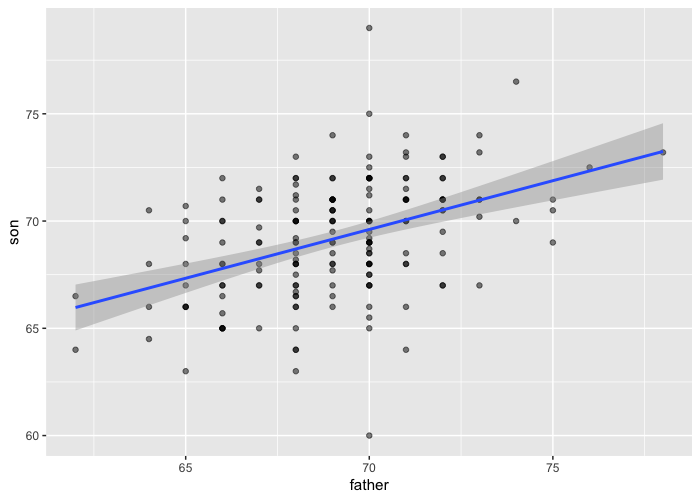

In [7]:
# visualize via geom_smooth(method = "lm"), i.e. regression line with confidence interval
galton_heights %>% 
  ggplot(aes(father, son)) + 
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm")

# in this example:
#    - correlation between heights is about 0.5
#    - our example prediction: son was 0.48 standard deviations larger than average,
#                              father was 1.1 standard deviations larger than average

# result: sons regress to average height.

### 4. Predicted Values = Random Variables

Fit model -> obtain predictions of y (via evaluation of estimates in regression model) -> get regression line by plotting predictions $\hat{y}$ versus $x$.

Keep in mind: $\hat{y}$ is random variable! (hence why `geom_smooth(method = "lm")` also plots confidence intervals)

`geom_smooth()` using formula 'y ~ x'


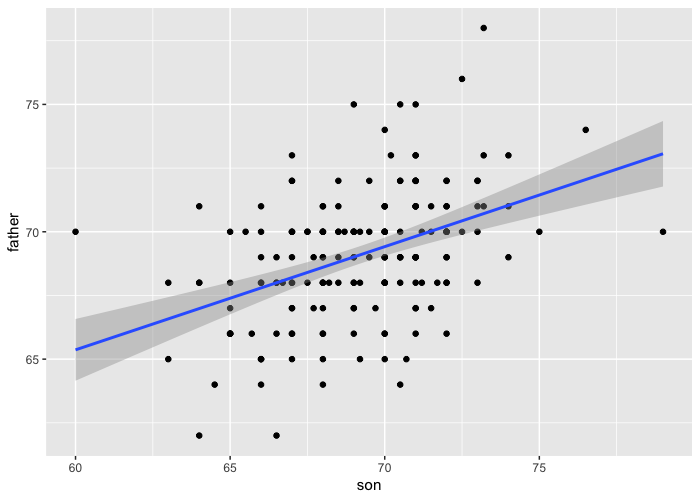

In [8]:
galton_heights %>% ggplot(aes(son, father)) +
  geom_point() +
  geom_smooth(method = "lm")

In [9]:
# prediction based on lm() input:
fit <- galton_heights %>% lm(son ~ father, data = .) 
y_hat <- predict(fit, se.fit = TRUE)
names(y_hat)

[1] "fit"            "se.fit"         "df"             "residual.scale"

### 5. Explained Variance

How well does model represent data/response?

Under linear regression assumptions: $SD(y|x) = \sigma_{y} \sqrt(1-\rho^{2})$ (intuition: standard deviation within groups (e.g. same father's height) lower than usual standard deviation).

---

Quantify in term of proportion of variance, e.g. $X$ explains $1-1(1-\rho^{2}) = \rho^{2}$ of the variance. Proportion of variance explained by model = $R^{2} \in [0,1]$.

Alternative:
1. $\hat{y}_{i} = \hat{\beta_{0}} + \hat{\beta_{1}} x_{i}$
2. $\hat\epsilon_{i} = y_{i} - \hat{y}_{i}$ (residual)
3. $RSS = \sum_{i=1}^{N} \hat\epsilon_{i}^{2}$ (residual sum of squares, variation around model predictions)
4. $R^{2} = 1 - \frac{RSS}{SS} = 1 - \frac{\sum_{i=1}^{N} \hat\epsilon_{i}^{2}}{\sum_{i=1}^{N} (y_{i} - \bar{y})^{2}}$ (SS = sum of squares, variation around global mean)

Hence: if model learned no variation, it learned the global mean ($R^{2} = 0$). If model fits perfect, then $R^{2} = 1$ as residuals are $0$.

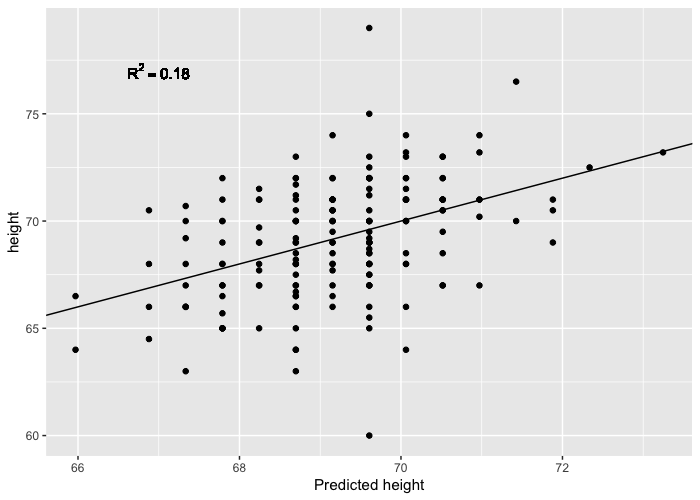

In [10]:
# show R^2 combined with scatter plot of y againts its prediction
m <- lm(son ~ father, data = galton_heights)
r2 <- summary(m)$r.squared

ggplot(galton_heights, aes(x=predict(m), y=son)) + geom_point() +
    geom_abline(intercept=0, slope=1) +
    geom_text(aes(x=67, y=77, 
                  label=deparse(bquote(R^2 == .(signif(r2, 2))))
                  ), parse=TRUE) +
    labs(x="Predicted height", y="height")

### 6. Testing Relationship: $y$ and $x$ (`summary(lm(...))`)

As LSE derived from realizations of random variables, estimates are random variables. Hence under assumption of independent Gaussian noise: $p(\hat\beta) = N(\beta, \frac{\sigma^{2}}{s_{X}^{2}})$ with variance of $X$ $s_{X}$.

Interpretation: if modeling assumptions hold, then estimates unbiased, i.e. their expected value = true values of $E[\hat\beta] = \beta$, and consistent, i.e. converge to their true values for infinitely large sample sizes.

---

Hypothesis test: $p(\frac{\hat{\beta} - \beta}{\hat{\mathrm{se}}(\hat\beta)}) = t_{n-2} (\frac{\hat{\beta} - \beta}{\hat{\mathrm{se}}(\hat\beta)})$ with student's $t$-distribution with $n-2$ degrees of freedom $t_{n-2}$ and standard error ${\hat{\mathrm{se}}(\hat\beta)} = \frac{\sigma^{2}}{n s_{X}^{2}}$.

Reminder: p-value of statistical test = prbability of value of test statistic being at least as extreme as the one observed in data under null hypothesis.

Here:
1. null hypothesis: $H_{0}: \beta_{i} = 0$
2. test statistic: $\hat{t} = \frac{\hat{\beta} - \beta_{i}}{\hat{\mathrm{se}}(\hat\beta)} = \frac{\hat{\beta}}{\hat{\mathrm{se}}(\hat\beta)}$
3. probability under null hypothesis: $P(t \geq \hat{t})$ where $t \sim t_{n-2}$

Confirm linear relationship between $x$, $y$ by rejecting null hypothesis, i.e.:
- accept $H_{0}$ if $P(|t| \geq |\hat{t}|) > \alpha (=0.05)$
- reject $H_{0}$ if $P(|t| \geq |\hat{t}|) \leq \alpha (=0.05)$

In [11]:
lm(son ~ father, data = galton_heights) %>% 
  summary %>% .$coef

# t-value = t-statistics
# Pr(>|t|) = p-value

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),37.775451,4.97272309,7.596532,1.693821e-12
father,0.454742,0.07192596,6.322363,2.034076e-09


In [12]:
# --------------------

## Multivariate Regression

Linear regression against multiple variables.

Problem: not always able to randomly assign each individual to control group. Hence confounding prevalent.

### 1. Multivariate Example: Baseball Dataset

Goal: predict game scores of a team.

#### 1.1 Baseball Basics

Goal: score more runs/points than other team.

Team: 9 batters (can hit ball with bat in predetermined order), pitcher (throws ball for other team).

Concept: batter tries to hit ball thrown by pitcher. If batter out, then return to bench. If batter hits balls as "home plate", he has to pass as many bases (4 in total, fourth = "home plate") as possible before opponent team catches ball. If batter stops at a base, he can resume running when other batter hits ball. If batter arrives at "home plate", he scores a run.

In our analysis: response variable = average number of runs.

#### 1.2 Home Runs

Home run: batter hits ball "all the way home", i.e. very far, and performs full run. Other batters on field can therefore also finish their runs.

Consequence: average home runs positively correlate with average runs.

`geom_smooth()` using formula 'y ~ x'


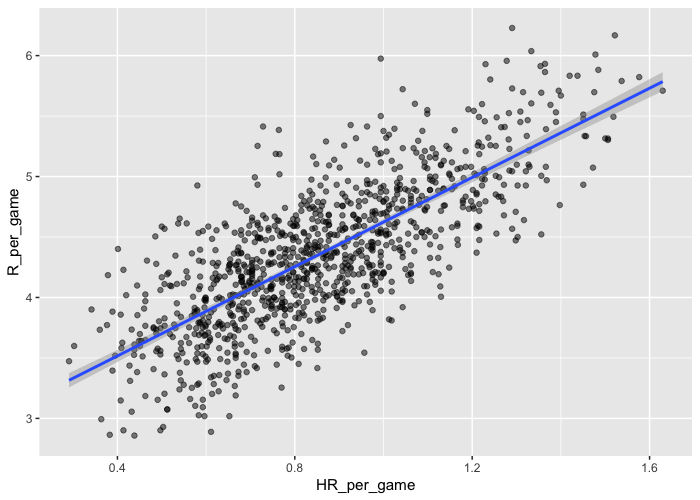

In [13]:
Teams <- as.data.table(Teams)
Teams_filt <- Teams[yearID %in% 1961:2001]
Teams_filt[,c('HR_per_game','R_per_game') := list(HR/G, R/G)]%>%
  ggplot(aes(HR_per_game, R_per_game)) + 
  geom_point(alpha = 0.5) +
  geom_smooth(method="lm")

In [14]:
# parameter estimates of univariate linear regression:
fit_r_vs_hr <- lm(R_per_game~HR_per_game, data=Teams_filt)
fit_r_vs_hr

# interpretation: if team hit 1 more HR per game than average team,
#    they score 1.845 (= slope) more runs per game than average team.


Call:
lm(formula = R_per_game ~ HR_per_game, data = Teams_filt)

Coefficients:
(Intercept)  HR_per_game  
      2.778        1.845  


#### 1.3 Base on Balls

Pitcher should throw ball at batter due to "base on balls" rule, i.e. if pitcher can't throw ball through predefined area ("strikezone"), batter can go to first base.

Conclusion: base on balls should be beneficial for score (although not as great as home run).

---

But: BBs and HRs also associated. As player in HR is guaranteed at least one run, could HRs cause BBs?

It turns out: pitcher afraid of HRs, hence sometimes cause BBs, i.e. HR hitters have more BBs.

Therefore: BBs confounded with HRs.

`geom_smooth()` using formula 'y ~ x'


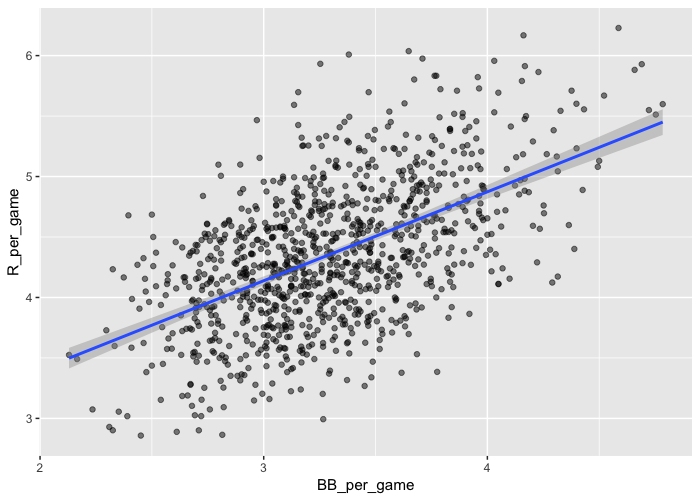

In [15]:
Teams_filt[,BB_per_game := BB/G]%>%
  ggplot(aes(BB_per_game, R_per_game)) + 
  geom_point(alpha = 0.5) +
  geom_smooth(method="lm")

# interpretation: clear association

In [16]:
get_slope <- function(x, y) cor(x, y) * sd(y) / sd(x)
bb_slope <- Teams_filt[,.(slope = get_slope(BB_per_game, R_per_game) )] 
bb_slope

slope
0.7353288


`geom_smooth()` using formula 'y ~ x'


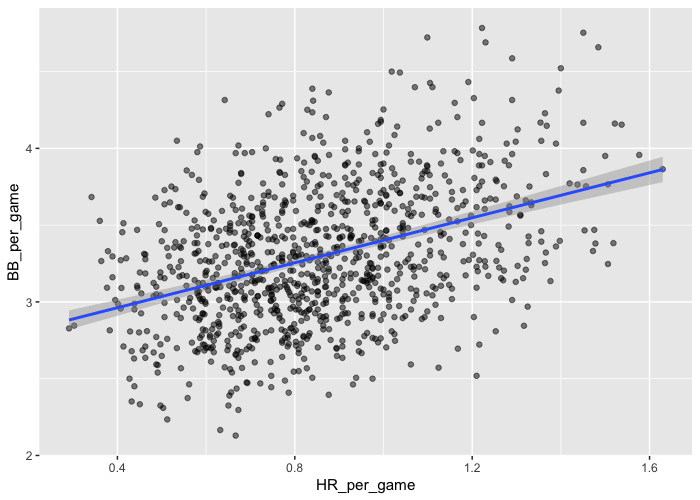

In [17]:
Teams_filt %>%
  ggplot(aes(HR_per_game, BB_per_game)) + 
  geom_point(alpha = 0.5) +
  geom_smooth(method="lm")

# interpretation: BBs and HR associated

#### 1.4 Understanding Confounding Through Stratification

First: untangle direct from indirect effects step-by-step via stratification to get concrete understanding of situation.

---

*Approach 1*:

Keep HRs fixed at certain value, then examine relationship between BBs and runs.

Hence: stratify HR per game to closes tenth, filter out strata with few points to avoid highly variable estimates, scatterplot for each strata.

Result: regression slope for predicting runs with BBs significantly reduced, but not 0. Therefore BBs helpful for preducing runs, but not as much as previously thought.

Helpful for understanding: stratify by BB and check if effect of BB goes down.

HR_strata,slope
0.4,0.7342910
0.5,0.5659067
0.6,0.4119129
0.7,0.2853933
0.8,0.3650361
0.9,0.2610262
1.0,0.5113967
1.1,0.4539252
1.2,0.4403274


`geom_smooth()` using formula 'y ~ x'


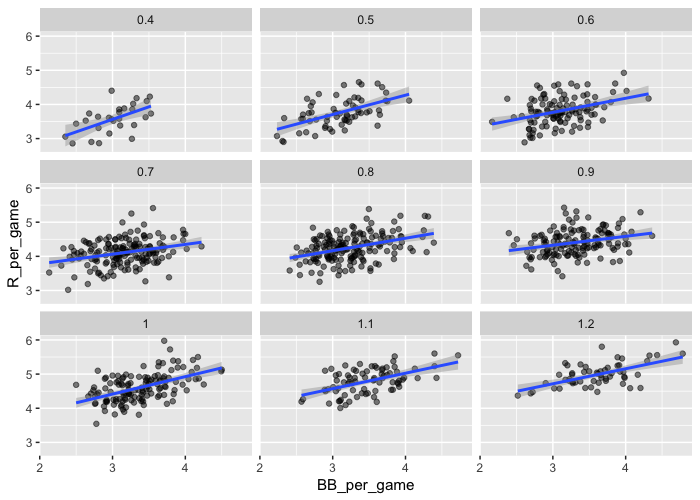

In [18]:
dat <- Teams_filt[,HR_strata := round(HR/G, 1)][HR_strata >= 0.4 & HR_strata <= 1.2]

dat[order(HR_strata),.(slope = get_slope(BB_per_game, R_per_game)), by='HR_strata']
# significantly smaller

dat %>% 
  ggplot(aes(BB_per_game, R_per_game)) +  
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm") +
  facet_wrap( ~ HR_strata)

BB_strata,slope
2.8,1.518056
2.9,1.567879
3.0,1.518179
3.1,1.494498
3.2,1.582159
3.3,1.560302
3.4,1.481832
3.5,1.631314
3.6,1.829929
3.7,1.451895


`geom_smooth()` using formula 'y ~ x'


slope
1.844824


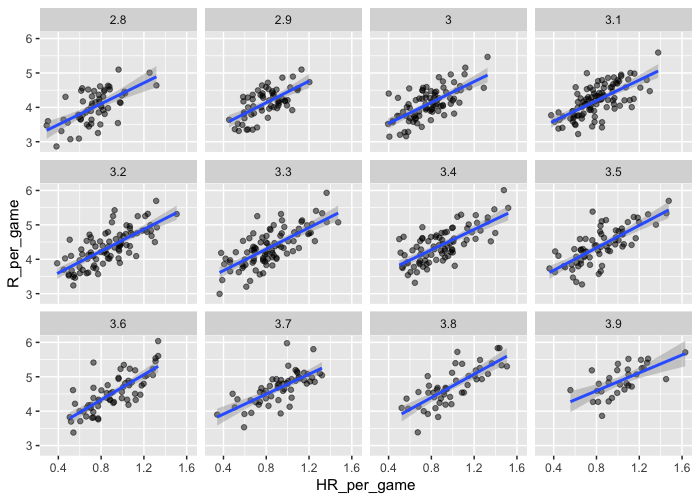

In [19]:
dat <- Teams_filt[,BB_strata := round(BB/G, 1)][BB_strata >= 2.8 & BB_strata <= 3.9]
dat[order(BB_strata),.(slope = get_slope(HR_per_game, R_per_game)), by='BB_strata']

dat %>% 
  ggplot(aes(HR_per_game, R_per_game)) +  
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm") +
  facet_wrap( ~ BB_strata)

# original slope
hr_slope <- Teams_filt[,.(slope = get_slope(HR_per_game, R_per_game))]
hr_slope

#### 1.5 Data Suggests Additive Effects

Complex to compute regression line for each strata, as fitting model like $E[R|BB=x_{1}, HR=x_{2}] = \beta_{0} + \beta_{1}(x_{2})x_{1} + \beta_{2}(x_{1})x_{2}$ (slopes for $x_{1}/x_{2}$ change for different values of $x_{2}/x_{1}$).

---

Take random variability into account, then slopes in strata don't change much. If slopes are the same, then $\beta_{1}(x_{1}), \beta_{2}(x_{2}) = const.$. Hence $E[R|BB=x_{1}, HR=x_{2}] = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$.

Model suggests:
1. if number of HR is fixed on $x_{2}$, then linear relationship between runs and BB with intercept $\beta_{0} + \beta_{2}x_{2}$. Also suggested by exploratory data analysis.
2. if number of HR grows, intercept growth linear and determined by $\beta_{1}x_{1}$.

---

Multivariate regression: "BB slope $\beta_{1}$ adjusted for HR effect, i.e. if model correct, then confounding accounted for.

### 2. Fitting Multivariate Regression

Multiple linear regression model: $y_{i} = \beta_{0} + \sum_{j=1}^{p} \beta_{j}x_{i,j} + \epsilon_{i}$ for data set $\{(x_{i}, y_{i})\}_{i=1}^{p}$, $x_{i} \in F^{p}$ with free paramters $\beta_{0}$, $\beta$ and random i.i.d. errors $\epsilon_{i} \sim N(0, \sigma^{2})$.

Model in matrix notation: $y = X\beta + \epsilon$ with $X \in F^{n \times p+1}$, $X_{i} = (1, x_{i})$ (1 for accommodating of intercept), $\epsilon \sim N(0, \Sigma)$, $\Sigma = \sigma^{2} I$.

Estimate paramters by finding LSE: $\hat\beta = (X^{T}X)^{-1}X^{T}y$, $\hat{\sigma}^{2} = \frac{\hat{\epsilon}^{T}\hat{\epsilon}}{N-p}$ with assumption that estimates unbiased (as in univariate case).

Therefore: $E[\hat{\beta}_{j}] = \beta_{j}$ (i.e. estimates unbiased) and $\hat{\beta}_{j} \rightarrow \beta_{j}$ for $n \rightarrow \infty$ (due to consistency of estimates).

In [20]:
# use lm(), but adapt to include all predictor variables
fit <- lm(R_per_game ~ HR_per_game + BB_per_game,
          data=Teams_filt)

coef(fit)
# coefficients for HRs and BBs similar to those estimated by stratification

summary(fit)

# other useful functions: predict(), resid()

(Intercept) HR_per_game BB_per_game 
  1.7443011   1.5611689   0.3874238


Call:
lm(formula = R_per_game ~ HR_per_game + BB_per_game, data = Teams_filt)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.87325 -0.24507 -0.01449  0.23866  1.24218 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.74430    0.08236   21.18   <2e-16 ***
HR_per_game  1.56117    0.04896   31.89   <2e-16 ***
BB_per_game  0.38742    0.02701   14.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3484 on 1023 degrees of freedom
Multiple R-squared:  0.6503,	Adjusted R-squared:  0.6496 
F-statistic: 951.2 on 2 and 1023 DF,  p-value: < 2.2e-16


### 3. Testing Sets of Parameters

#### 3.1 Nested Models

Problem: testing individual parameters may not suffice.

Solution: nested models, i.e. test set of variables.

Method: compare full model $\Omega$ to reduced model $\omega$ (special case of $\Omega$), usually by setting set of parameters to $0$ in $\omega$.

---

*Example*:

$y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3}$

Full model: all $\beta$s can take any value.

Reduced model: $\beta_{1} = \beta_{2} = 0$

#### 3.2  F-test and ANOVA

F-test: compare two nested linear regressions, based on comparing fit improvements (measured by change $RSS$).

Question: improvement significant under null hypothesis that smaller model is correct. (Reminder: larger model always fits better to data)

Definition: statistic $F = \frac{(RSS_{\omega} - RSS_{\Omega}) / (q-p)}{RSS_{\Omega} / (n-q)}$ with $q =$ #(parameters in $\Omega$), $p =$ #(parameters in $\omega$). $F$ distributed according to F-distribution with $(q-p)$, $(n-q)$ degrees of freedom respectively.

Reject LRT if $F$ larger than critical value ($\approx$ significance level). ("ANOVA")

---

*Example*: test difference of means in 3 groups.

Model: $y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$ with indicator variables $x_{1}$ (= $1$ if group "6 cylinders"), $x_{2}$ (= $1$ if group "8 cylinders").

Test effect of both indicators at same time:
- $H_{0}: \beta_{1} = \beta_{2} = 0$
- full model $\Omega$: all $\beta$ can take any value
- reduced model $\omega$: only $\beta_{0}$ can take any value

Result: full model significantly better than reduced model (contains only intercept).

Conclusion: there is difference in means of the 3 groups.

In [21]:
data("mtcars")
## for the example we need a factor
## else it will be interpreted as number
mtcars$cyl <- as.factor(mtcars$cyl)
## fit the full model
full <- lm(mpg ~ cyl, data=mtcars)
## have a look at the model matrix
## which is automatically created
head(model.matrix(full))

## fit the reduced model (only the intercept "1")
reduced <- lm(mpg ~ 1, data=mtcars)

## compare the models
anova(reduced, full)

,(Intercept),cyl6,cyl8
Mazda RX4,1,1,0
Mazda RX4 Wag,1,1,0
Datsun 710,1,0,0
Hornet 4 Drive,1,1,0
Hornet Sportabout,1,0,1
Valiant,1,1,0


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
31,1126.0472,NA,NA,NA,NA
29,301.2626,2,824.7846,39.69752,4.978919e-09


In [22]:
# --------------------

## Diagnostic Plots

Problem: mathematical assumption will never hold exectly in praxis, hence
1. how badly does dataset violate assumptions?
2. what are implications for claimed solution?
3. how to adress issue?

Assumptions of linear regression:
1. expected values of response are linear combinations of explanatory variables
2. errors i.i.d.
3. errors follow normal distribution

### 1. Assessing Non-Linearity with Residual Plot

*Diagnostic plot*:

Non-linearity revealed by noticing that average of residual depends on predicted values. Smooth fit (`geom_smooth()`) on residual plot ($\hat{\epsilon} \sim \hat{y}$) can help, see https://gagneurlab.github.io/dataviz/chap-lin-reg.html#fig:non-linear-qc.

---

Implication of non-linearity depends on application purposes:
1. Prediction suboptimal. Could be improved with more complex model (but may not be better on unseen data ...).
2. Explained variance underestimated.
3. i.i.d. assumption violated. Residuals depend on predicted mean, i.e. errors depend on $E[y|x]$ and therefore on each other. Hence statistical tests flawed.
4. Conditional independence affected. Can be seen via: assume model where $x$, $y$ depend on common cause $z$ in non-linear fashion. Then $x$, $y$ independent conditioned on $z$. But linear regression on $y$ on $x$, $z$ would fail to discard distribution of $x$.

---

*What to do*: if non-linearity revealed in fit, then trafo explanatory variables or response. But appropriate trafos hard to know/find.

In `R`: use `formula` (has few good trafo functions) while calling `lm()`, e.g. `model <- lm(y ~ poly(x,3))` fits polynomial of degree 3.

### 2. When Error Variance Not Constant: Heteroscedascity

Situation: variance of residual not constant across all data points ("Heteroscedascity"), i.e. violation of i.i.d. assumption of errors.

---

*Diagnostic plot*:

Residual plots help spotting when error variance depends on response mean, see plot.

---

For prediction: problem only maybe issue. Fit can bedriven by few data points as LSE give much importance to points with high noise. Hence only really a problem with low number of points in areas with large noise.

Statistical tests flawed as residual not i.i.d.

---

*What to do*:
1. Try to trafo response variable $y$ (e.g. via log-trafo, square toot, variable stabilizing trafos). However: appropriate trafos hard to know/find.
2. Use methods with different noise model, e.g. weigthed LS, generalized models.

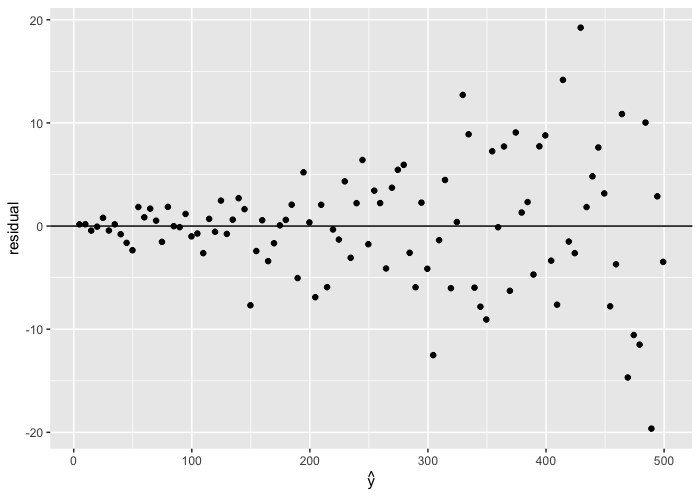

In [23]:
x <- 1:100
y <- rnorm(100, mean=5 * x, sd=0.1*x)
m <- lm(y ~ x)
ggplot(data=NULL, aes(predict(m), resid(m))) + 
    geom_point() + geom_abline(intercept=0, slope=0) +
    labs(x=expression(hat(y)), y="residual")

### 3. Gaussianity: Q-Q-Plot of Residuals

Gaussian assumption on errors = key to all statistical tests.

If errors follow Gaussian assumption, then residuals follow Gaussian assumption.

---

*Diagnostic plot*:

Use Q-Q-plot of residuals against normal distribution.

`qqnorm`, `qqline`: Q-Q-plot against Gaussian fitted to input vector.

---

If residuals not Gaussian, then noise model is wrong. Implications:
1. With enough data, regression lines might not be too affected by LSE converging to expected values. (Reminder: LS on fit and prediction independent of Gaussian assumption.)
2. Hypothesis testing flawed.

---

*What to do*: we work with fundamentally non-Gaussian data (e.g. Poisson distributed) or with data with long tails and outliers. Hence
1. if known what could be better noise model: generalized linear model with another distribution.
2. else: case resampling to estimate confidence intervals.

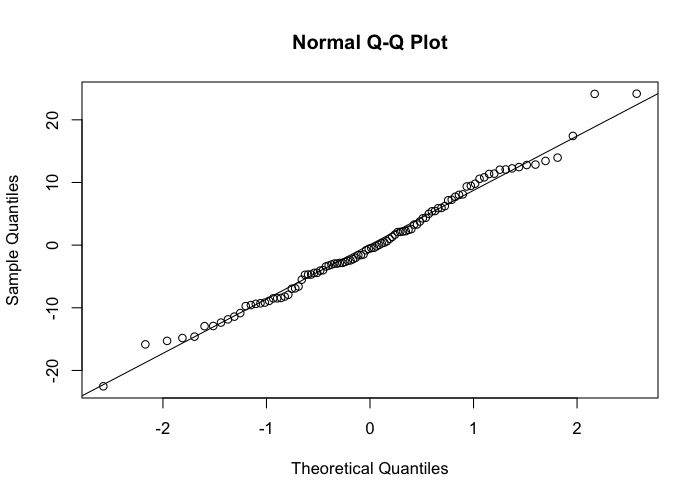

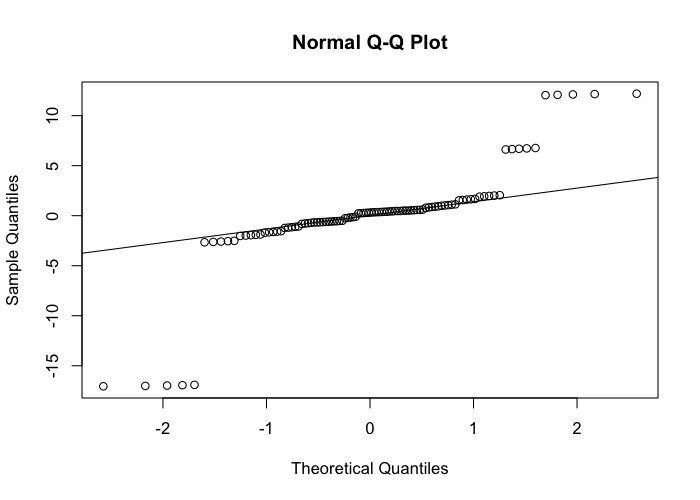

In [24]:
# good example: Gaussian
set.seed(0)
x <- 1:100
y <- rnorm(100, mean=5 * x, sd=10)
m <- lm(y ~ x)
qqnorm(residuals(m))
qqline(residuals(m))

# bad example: t-distribution
set.seed(0)
x <- 1:100
y <- x + rt(20, df=1)
m <- lm(y ~ x)
qqnorm(residuals(m))
qqline(residuals(m))

In [25]:
# --------------------

## Conlusions

Linear models:
- powerful, versatile
- used to:
    - predict future data
    - quantify explained variance
    - access linear relationship between variables (hypothesis testing)
    - control for confounding (multiple linear regression)
- check assumptions! (diagnosic plots)
- can be generalized for different distributions

##### End of Section 10!